In [1]:
%pip install japanize-matplotlib

Note: you may need to restart the kernel to use updated packages.


SH001の傾きは152.80142013225574、決定係数R^2は0.9596404939113314
ベースラインのDA濃度は0.7983728154778315 pg/1ml
SH002の傾きは194.45807494489355、決定係数R^2は0.9995302038628299
ベースラインのDA濃度は0.35133537149002864 pg/1ml


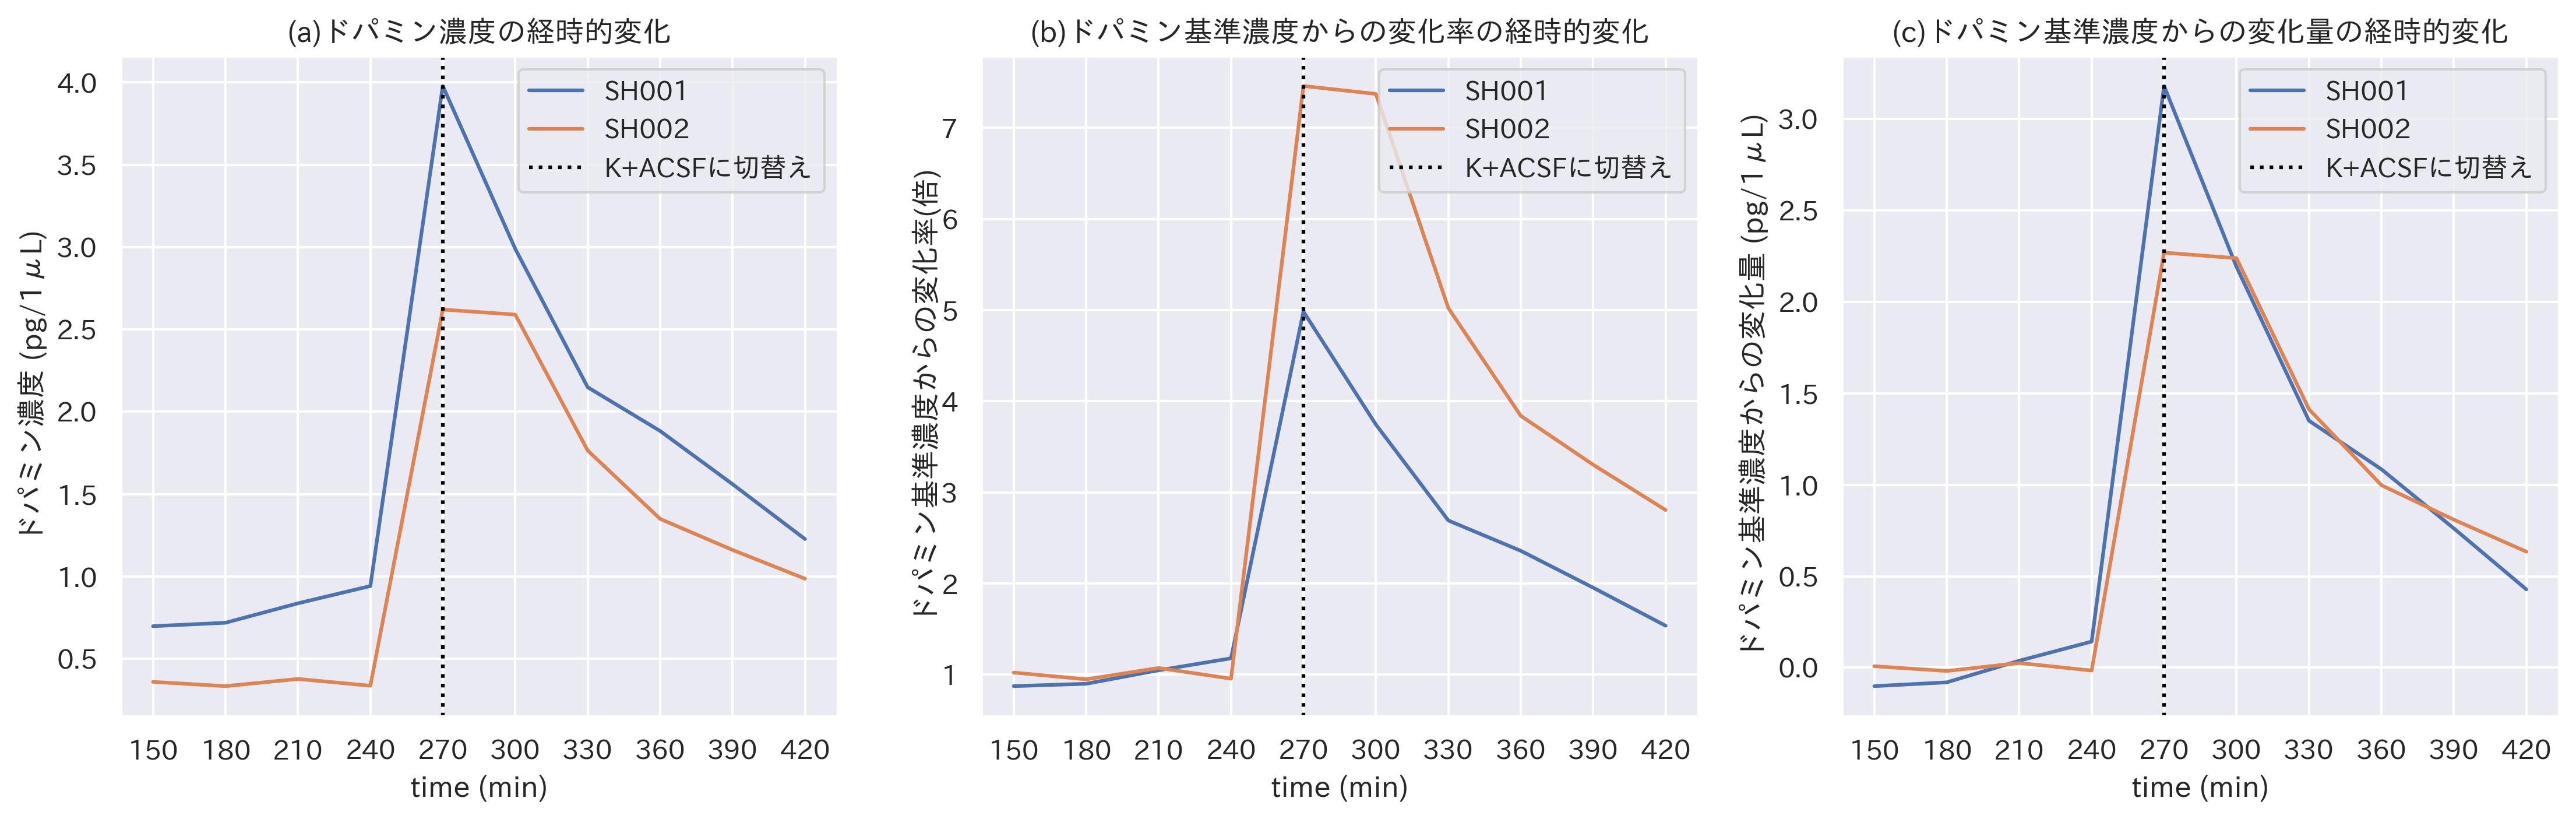

In [15]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import seaborn as sns
sns.set()
import japanize_matplotlib
japanize_matplotlib.japanize()
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
import glob

#============================================================
#設定項目
#============================================================
#一つのグラフに入れるデータは、一つのディレクトリにまとめておく
data_directory = "/home/biofunc/data220122"

#サンプルの種類ごとの個数、順番
sample_lot = [5, 4, 4, 6]
sample_order = {'str':0, 'pro':1, 'baseline':2, 'fruction':3}

#サンプル抽出の時間間隔
time_series = 30

#スタンダードのドパミン濃度
#x_DAstr_pg = np.array([10, 5, 2.5, 1.25, 0.3125])
#今回だけスタンダードの濃度が違うので、特例
x_sh001_DAstr_pg = 10 * np.array([10, 5, 2.5, 1.25, 0.3125])
x_sh002_DAstr_pg = np.array([10, 5, 2.5, 1.25, 0.3125])
x_DAstr_pg = [x_sh001_DAstr_pg, x_sh002_DAstr_pg]

#グラフのラベル
graph_xlabel = 'time (min)'
graph_ylabel = ['ドパミン濃度 (pg/1μL)', 'ドパミン基準濃度からの変化率(倍)', 'ドパミン基準濃度からの変化量 (pg/1μL)']
graph_title = ['(a)ドパミン濃度の経時的変化', '(b)ドパミン基準濃度からの変化率の経時的変化', '(c)ドパミン基準濃度からの変化量の経時的変化']
graph_line_x = 270
graph_line_label = 'K+ACSFに切替え'
#============================================================
#============================================================

#以下、普遍的な処理
data_path = glob.glob(os.path.join(data_directory, "*.csv"))
#A(mV*s)のデータの列番号は４番
data = [pd.read_table(i).iloc[:,4] for i in data_path] #power chromのテキストデータを直接取り込むようになったら、ilocの変数は調節しないとならない
sample_lot = [0] + sample_lot
sample_type_start_and_end = [[np.sum(sample_lot[:i+1]), np.sum(sample_lot[:i+2])] for i in range(len(sample_lot)-1)]
#データの種類ごとの切り出し
data_str = [data[i][sample_type_start_and_end[sample_order['str']][0]:sample_type_start_and_end[sample_order['str']][1]:1] for i in range(len(data))]
data_baseline = [data[i][sample_type_start_and_end[sample_order['baseline']][0]:sample_type_start_and_end[sample_order['baseline']][1]:1] for i in range(len(data))]
data_fruction = [data[i][sample_type_start_and_end[sample_order['fruction']][0]:sample_type_start_and_end[sample_order['fruction']][1]:1] for i in range(len(data))]
#横軸の準備
experience_totaltime = time_series*(len(data[0]) - len(data_str[0]))
x_time = np.linspace(0, experience_totaltime, len(data[0])-len(data_str[0])+1)
#サンプル名を、CSVファイルの名前から抽出する
sample_name = [os.path.splitext(os.path.basename(i))[0] for i in data_path]

#グラフ作成
fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=300)
x_time_range = x_time[sample_type_start_and_end[sample_order['baseline']][0] - len(data_str[0]) + 1: sample_type_start_and_end[sample_order['fruction']][1] - len(data_str[0]) + 1: 1]
for i in range(len(data)):
    str_model = LinearRegression(fit_intercept=False)
    str_model.fit(x_DAstr_pg[i][:, np.newaxis], data_str[i]) #スタンダード統一できたらここ調整
    str_fit = str_model.predict(x_DAstr_pg[i][:, np.newaxis])
    baseline = np.average(data_baseline[i]) / str_model.coef_[0]
    ax[0].plot(x_time_range, np.concatenate([data_baseline[i], data_fruction[i]]) / str_model.coef_[0], label=sample_name[i])
    ax[1].plot(x_time_range, np.concatenate([data_baseline[i], data_fruction[i]]) / (str_model.coef_[0] * baseline), label=sample_name[i])
    ax[2].plot(x_time_range, np.concatenate([data_baseline[i], data_fruction[i]]) / (str_model.coef_[0]) - baseline, label=sample_name[i])
    print(f'{sample_name[i]}の傾きは{str_model.coef_[0]}、決定係数R^2は{r2_score(data_str[i], str_fit)}')
    print(f"ベースラインのDA濃度は{baseline} pg/1ml")

#サンプル切替え時点ラインの挿入、横軸間隔、軸名、データ名の設定
for i in range(len(graph_ylabel)):
    ax[i].axvline(x=graph_line_x, color='black', linestyle=':', label=graph_line_label)
    ax[i].set(xlabel=graph_xlabel, ylabel=graph_ylabel[i], title=graph_title[i], xticks=x_time_range)
    ax[i].legend();

# テキストをテキストとして出力する設定
plt.rc("svg", fonttype="none")
# SVGとして保存
fig.savefig(os.path.join(data_directory, "sample.svg"))